In [12]:
import os
import sys
import warnings

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
sys.path.append(os.getcwd())
sys.path.append("..")
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

import src, models

In [ ]:
TRAIN_DATA_PATH = "MVTec/bottle/train/good"
TEST_DATA_PATH = "MVTec/bottle/test"

In [14]:
H, W = 256, 256
C = 3

# Train (normal images)
train_files = src.data.path_to_files(TRAIN_DATA_PATH)
train_imgs = src.data.files_to_imgs(train_files, img_mode="rgb", resizes=(H, W))
print(f"Shape of training images: {train_imgs.shape}", flush=True)

# Test
test_files = src.data.path_to_files(TEST_DATA_PATH)
test_imgs = src.data.files_to_imgs(test_files, img_mode="rgb", resizes=(H, W))
print(f"Shape of test images: {test_imgs.shape}", flush=True)

Shape of training images: (209, 256, 256, 3)
Shape of test images: (83, 256, 256, 3)


In [15]:
# Get the feature extractor
src.utils.reset_seed(0)

feature_extractor = models.model.get_feature_extractor(
    input_shape=(H, W, C),
    output_shape=(64, 64, 32 * 3),
    model_type="v2",
)

In [16]:
feature_extractor.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 bi_esn2d_5 (BiESN2D)        (None, 256, 256, 32)         384       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 128, 128, 32)         0         ['bi_esn2d_5[0][0]']          
 g2D)                                                                                             
                                                                                                  
 bi_esn2d_6 (BiESN2D)        (None, 128, 128, 64)         3136      ['max_pooling2d_4[0][0]'

In [17]:
# Calculate the statistics of the normal distribution
normal_statistics = models.padim_framework.cal_statistics(
    normal_imgs=train_imgs,
    feature_extractor=feature_extractor,
    prioritize_memory=False,
)

# Calculate the anomaly scores
anomaps = models.padim_framework.cal_mahalanobis_distance(
    input_imgs=test_imgs,
    normal_statistics=normal_statistics,
    feature_extractor=feature_extractor,
    prioritize_memory=False,
)

# Create the anomaly maps
anomaps = keras.layers.Resizing(H, W, interpolation="bilinear")(anomaps)
anomaps = anomaps.numpy().reshape(-1, H, W)
anomaps = (anomaps - np.min(anomaps)) / (np.max(anomaps) - np.min(anomaps))

Cal Cov: 100%|██████████| 4096/4096 [00:02<00:00, 1926.92it/s]


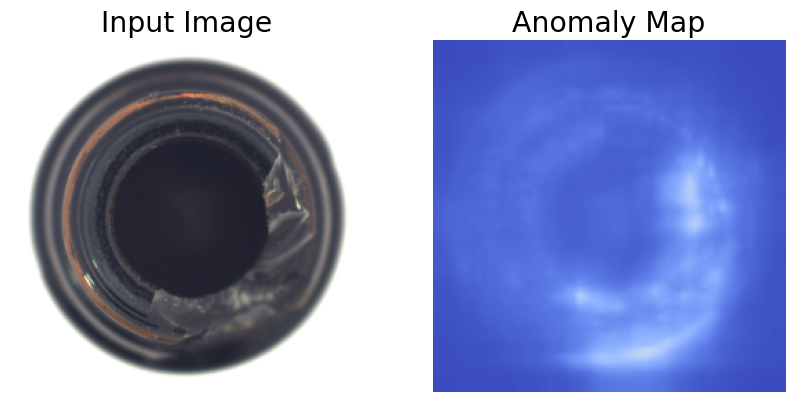

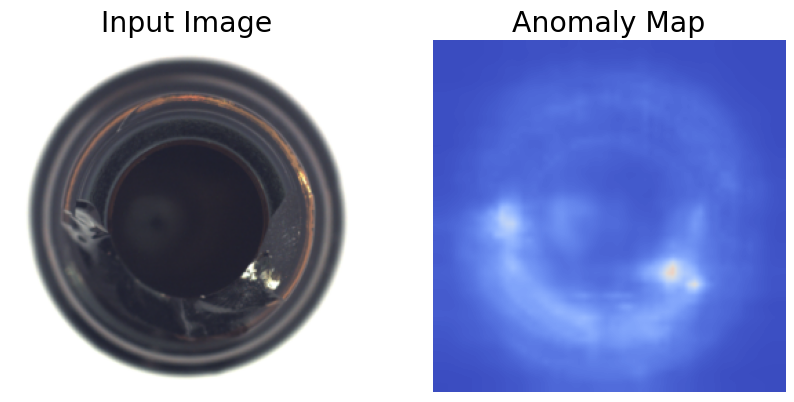

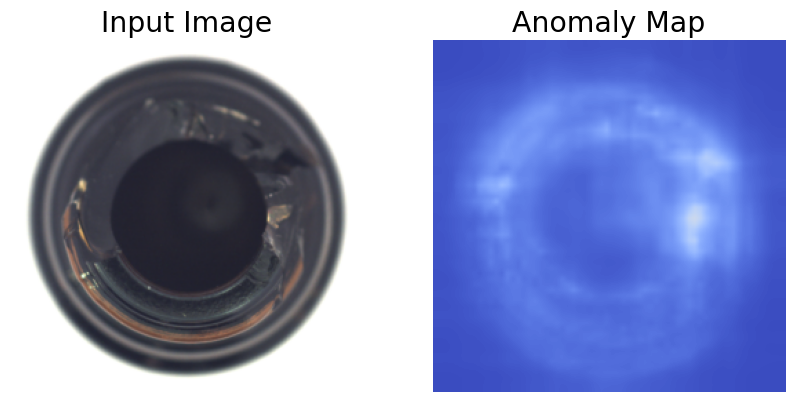

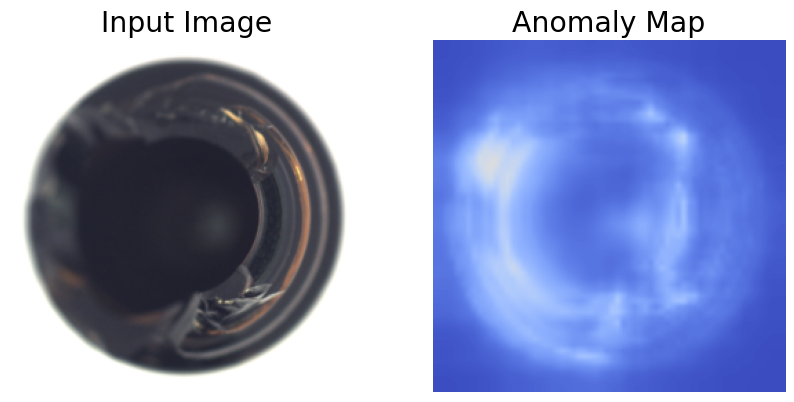

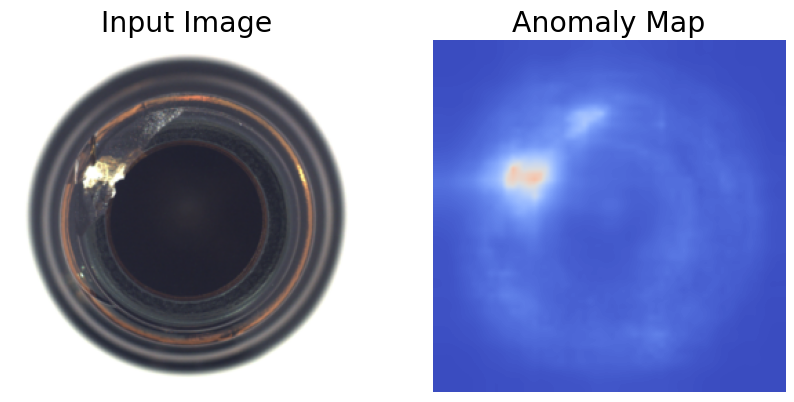

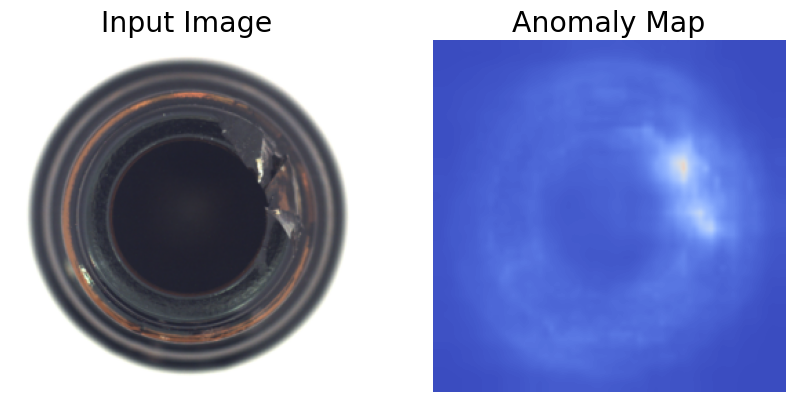

In [18]:
for idx, (anomap, test_img) in enumerate(zip(anomaps, test_imgs)):
    if idx > 5:
        break

    plt.figure(figsize=(10, 5))

    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.title(["Input Image", "Anomaly Map"][i])
        plt.imshow(
            [test_img, anomap][i],
            cmap=["viridis", "coolwarm", "gray", "gray"][i],
            vmin=0.0,
            vmax=1.0,
        )
        plt.axis("off")

    plt.show()
    plt.close()

In [19]:
import gc

gc.collect()

62502